<table>
    <tr>
        <td><img src="macc.jpg" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Aprendizaje Automático de Maquina: Proyecto 2</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Red Neuronal para Clasificar Vocales en Audio</p></tp>
                <tp><p style="font-size:100%;text-align:center">Rafael Cabrera </p></tp>
                <tp><p style="font-size:100%;text-align:center">Oscar Velasco </p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

08 de Mayo de 2022

# Proyecto II

El objetivo es generar una red neuronal que pueda reconocer que vocal ha pronunciado una persona.

Para la realización de este proyecto deben:

1. Crear una base de datos con señales de personas diciendo las diferentes vocales. Tenga en cuenta las sigueintes consideraciones:
    * Una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades de como se pueden mencionar esas vocales. Además la base de datos debe contener diferentes muestras de diferentes personas, incluyendo niños, niñas, mujeres y hombres. El objetivo es generalizar, no memorizar patrones, para esto debemos darle suficiente información a la red.
    * Una señal de voz puede tener entre 8000 y 40000 mmuestras por segundo de grabación. Esto es bastante para ser utilizado como entrada en la red. recuerde que entre mayor dimensionalidad en los datos de entrada, mayor será la complejidad de la red necesaria. Para disminuir la complejidad pueden usar la densidad espectral de potencia (PSD) utilizando un número fijo de bins frecuenciales. La PSD representa la distribucion en frecuencia de la potencia de la señal.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.

Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir se debe poder probar con cualquier señal, se ingresa la señal de voz y el programa debería indicar que vocal se pronunció.

Deben contestar las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

## Cargar los Audios de las Vocales

In [1]:
import os
import collections as cll
import python_speech_features as psf
import scipy.io.wavfile as wav
import pandas as pd
import keras as kr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa as lbr
import time as tm

In [2]:
folder = 'new_vocals/'
files = sorted(os.listdir(folder))
len(files)

1685

In [3]:
begin = []
for i in files:
    begin.append(i[0])
count = dict(cll.Counter(begin))
print(count)
sum(count.values())

{'a': 341, 'e': 341, 'i': 336, 'o': 340, 'u': 327}


1685

## Extraer Características de los Audios

In [4]:
registers = []
classes = {'a':0, 'e':1, 'i':2, 'o':3, 'u':4}
t1 = tm.time()
for i in files:
    rate, sig = wav.read(folder + i)
    mfcc_feat = psf.mfcc(sig, rate, nfft=1200)
    y, sr = lbr.load(folder + i)
    spec_cent = np.mean(lbr.feature.spectral_centroid(y=y, sr=sr)[0])
    spec_bw = np.mean(lbr.feature.spectral_bandwidth(y=y, sr=sr)[0])
    rolloff = np.mean(lbr.feature.spectral_rolloff(y=y, sr=sr)[0])
    zcr = np.mean(lbr.feature.zero_crossing_rate(y)[0])
    # register = [i] + list(mfcc_feat[0]) + [i[0], classes[i[0]]]
    aux = [spec_cent, spec_bw, rolloff, zcr]
    register = [i] + list(np.mean(mfcc_feat, 0)) + aux + [i[0], classes[i[0]]]
    registers.append(register)
    # print(i, mfcc_feat.shape)
t2 = tm.time()
print('Time Execution:', t2 - t1)

Time Execution: 465.9425320625305


In [5]:
coefs = [f'coef{i}' for i in range(1, 14)]
others = ['spec_cent', 'spec_bw', 'rolloff', 'zcr']
names = ['name'] + coefs + others + ['vocal', 'class']
data = pd.DataFrame(data=registers, columns=names)
data.head()

,name,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13,spec_cent,spec_bw,rolloff,zcr,vocal,class
0,a1.wav,17.037942,17.679548,-17.678985,-2.140438,-17.723112,1.968608,-21.521891,-12.153522,-5.120405,-8.816086,-10.497291,1.582235,1.030568,1349.064787,1579.104290,2411.718750,0.061951,a,0
1,a10.wav,16.229338,19.061145,-6.987500,-4.283071,-14.064322,1.233451,-10.365662,-0.194640,-3.359466,5.180771,0.878571,3.480624,-4.588597,1024.858613,1345.754477,1716.159163,0.046698,a,0
2,a100.wav,19.190223,21.771804,-15.487817,-6.730023,-38.332168,-21.505178,-14.591654,-2.385162,-2.112266,10.727446,-2.392905,0.443476,-14.989165,1253.011244,1381.918029,1687.145354,0.063374,a,0
3,a101.wav,18.910462,21.575383,-24.013718,2.539285,-16.751548,-20.514427,-38.704705,13.243430,-3.598240,-16.279016,2.075196,6.607306,4.263353,1489.310659,1585.633737,3355.511944,0.058363,a,0
4,a102.wav,18.649902,17.706865,-21.297615,-0.860014,-29.449949,-30.176527,-18.438649,17.727833,6.315242,-5.177124,-8.093378,-11.677008,12.831736,1439.562051,1553.834796,2463.398438,0.077734,a,0


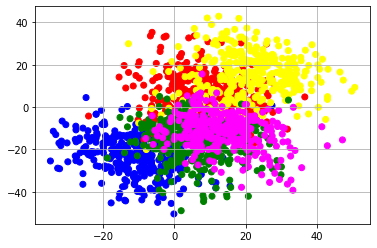

In [6]:
colors = {'a':'blue', 'e':'red', 'i':'yellow', 'o':'green', 'u':'magenta'}
plt.scatter(data['coef4'], data['coef5'], color=[colors[i] for i in data['vocal']])
plt.grid()

## Crear Red Neuronal para Clasificación

In [7]:
network1 = kr.models.Sequential()
network1.add(kr.layers.Dense(200, activation='relu', input_dim=13))
network1.add(kr.layers.Dense(100,activation='relu'))
network1.add(kr.layers.Dense(20,activation='relu'))
# network1.add(kr.layers.Dense(20,activation='relu'))
network1.add(kr.layers.Dense(5,activation='sigmoid'))
network1.compile(optimizer = 'rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [8]:
network2 = kr.models.Sequential()
network2.add(kr.layers.Dense(200, activation='relu', input_dim=17))
network2.add(kr.layers.Dense(100,activation='relu'))
network2.add(kr.layers.Dense(20,activation='relu'))
# network2.add(kr.layers.Dense(20,activation='relu'))
network2.add(kr.layers.Dense(5,activation='sigmoid'))
network2.compile(optimizer = 'rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [9]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, 1:18]
Y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [10]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [11]:
network1.fit(X_train.iloc[:, :13], train_labels, epochs=100, batch_size=150)

Epoch 1/100
9/9 [==============================] - 1s 4ms/step - loss: 1.5485 - accuracy: 0.6010
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.4161 - accuracy: 0.8393
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8876
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3861 - accuracy: 0.8519
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2357 - accuracy: 0.9137
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.2259 - accuracy: 0.9184
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2653 - accuracy: 0.8923
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2513 - accuracy: 0.9026
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9192
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9477
Epoch 11/100
9/9 [===========

9/9 [==============================] - 0s 4ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 85/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 87/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0662 - accuracy: 0.9818
Epoch 88/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 89/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.9992
Epoch 90/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.9984
Epoch 91/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0096 - accuracy: 0.9984
Epoch 92/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9905
Epoch 93/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0078 - accuracy: 0.9960
Epoch 94/100
9/9 [===============

In [12]:
network2.fit(X_train.iloc[:, :17], train_labels, epochs=100, batch_size=150)

Epoch 1/100
9/9 [==============================] - 1s 4ms/step - loss: 130.7207 - accuracy: 0.2700
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 52.0322 - accuracy: 0.3990
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 52.3635 - accuracy: 0.3737
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 49.2835 - accuracy: 0.3484
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 42.6383 - accuracy: 0.3927
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 40.7834 - accuracy: 0.4529
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 36.4504 - accuracy: 0.4268
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 45.2645 - accuracy: 0.3626
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 30.1546 - accuracy: 0.5123
Epoch 10/100
9/9 [==============================] - 0s 4ms/step - loss: 35.6585 - accuracy: 0.4355
Epoch 11/100
9/9 [

9/9 [==============================] - 0s 3ms/step - loss: 2.7056 - accuracy: 0.6247
Epoch 85/100
9/9 [==============================] - 0s 3ms/step - loss: 1.2212 - accuracy: 0.7458
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 1.8072 - accuracy: 0.6904
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 0.9489 - accuracy: 0.7862
Epoch 88/100
9/9 [==============================] - 0s 4ms/step - loss: 1.3071 - accuracy: 0.7292
Epoch 89/100
9/9 [==============================] - 0s 4ms/step - loss: 1.1039 - accuracy: 0.7371
Epoch 90/100
9/9 [==============================] - 0s 4ms/step - loss: 1.1320 - accuracy: 0.7039
Epoch 91/100
9/9 [==============================] - 0s 3ms/step - loss: 0.8854 - accuracy: 0.7332
Epoch 92/100
9/9 [==============================] - 0s 3ms/step - loss: 1.3925 - accuracy: 0.6793
Epoch 93/100
9/9 [==============================] - 0s 4ms/step - loss: 1.0114 - accuracy: 0.7102
Epoch 94/100
9/9 [===============

In [13]:
test_loss1, test_acc1 = network1.evaluate(X_test.iloc[:, :13], test_labels)
print('test_acc:', test_acc1)

14/14 [==============================] - 0s 2ms/step - loss: 0.4093 - accuracy: 0.8981
test_acc: 0.8981042504310608


In [14]:
test_loss2, test_acc2 = network2.evaluate(X_test.iloc[:, :17], test_labels)
print('test_acc:', test_acc2)

14/14 [==============================] - 0s 2ms/step - loss: 0.6036 - accuracy: 0.7583
test_acc: 0.758293867111206


In [15]:
classes_rev = {classes[i]:i for i in classes}
classes_rev

{0: 'a', 1: 'e', 2: 'i', 3: 'o', 4: 'u'}

In [16]:
y_test = [classes_rev[i] for i in list(y_test)]
print(y_test)
dict(cll.Counter(y_test))

['u', 'a', 'u', 'o', 'e', 'u', 'u', 'o', 'o', 'e', 'u', 'e', 'e', 'i', 'o', 'o', 'i', 'o', 'e', 'a', 'a', 'e', 'e', 'u', 'u', 'o', 'o', 'i', 'e', 'u', 'e', 'u', 'u', 'o', 'a', 'u', 'e', 'o', 'i', 'i', 'o', 'a', 'e', 'e', 'i', 'a', 'a', 'o', 'i', 'u', 'e', 'e', 'o', 'e', 'i', 'o', 'u', 'e', 'i', 'i', 'e', 'e', 'o', 'o', 'e', 'e', 'u', 'a', 'o', 'u', 'i', 'a', 'u', 'o', 'i', 'i', 'o', 'e', 'i', 'u', 'a', 'o', 'a', 'e', 'i', 'a', 'i', 'a', 'i', 'a', 'o', 'a', 'o', 'u', 'i', 'e', 'e', 'u', 'a', 'e', 'a', 'e', 'a', 'u', 'a', 'u', 'a', 'o', 'e', 'i', 'u', 'i', 'o', 'u', 'e', 'i', 'o', 'e', 'o', 'o', 'i', 'a', 'a', 'u', 'o', 'i', 'o', 'e', 'o', 'o', 'o', 'a', 'a', 'u', 'i', 'i', 'o', 'a', 'o', 'a', 'a', 'e', 'i', 'u', 'i', 'a', 'e', 'e', 'a', 'i', 'e', 'o', 'o', 'a', 'u', 'a', 'o', 'a', 'i', 'o', 'i', 'a', 'o', 'a', 'e', 'e', 'e', 'o', 'i', 'e', 'u', 'u', 'e', 'i', 'i', 'u', 'i', 'a', 'a', 'i', 'i', 'a', 'i', 'u', 'u', 'e', 'u', 'e', 'u', 'a', 'a', 'u', 'o', 'o', 'o', 'e', 'o', 'o', 'o', 'e',

{'u': 83, 'a': 86, 'o': 88, 'e': 85, 'i': 80}

In [17]:
y_pred1 = [list(i).index(max(list(i))) for i in network1.predict(X_test.iloc[:, :13])]
y_pred1 = [classes_rev[i] for i in list(y_pred1)]
print(y_pred1)
dict(cll.Counter(y_pred1))

['u', 'a', 'u', 'o', 'e', 'u', 'u', 'o', 'o', 'e', 'u', 'e', 'e', 'i', 'o', 'o', 'i', 'o', 'e', 'a', 'a', 'e', 'e', 'u', 'u', 'o', 'o', 'i', 'i', 'u', 'e', 'u', 'u', 'u', 'a', 'o', 'e', 'o', 'i', 'i', 'o', 'a', 'e', 'e', 'i', 'a', 'o', 'o', 'i', 'e', 'e', 'e', 'o', 'e', 'i', 'o', 'u', 'e', 'i', 'i', 'e', 'e', 'o', 'o', 'e', 'e', 'u', 'a', 'u', 'o', 'i', 'a', 'u', 'u', 'i', 'i', 'o', 'e', 'i', 'u', 'a', 'o', 'a', 'e', 'i', 'a', 'e', 'a', 'i', 'a', 'o', 'a', 'o', 'o', 'i', 'e', 'e', 'o', 'a', 'e', 'a', 'e', 'a', 'u', 'a', 'u', 'a', 'u', 'e', 'e', 'o', 'i', 'o', 'u', 'e', 'i', 'o', 'e', 'o', 'o', 'i', 'a', 'a', 'u', 'o', 'i', 'o', 'e', 'o', 'o', 'o', 'a', 'a', 'u', 'i', 'i', 'u', 'a', 'o', 'a', 'a', 'e', 'i', 'u', 'i', 'a', 'e', 'e', 'a', 'i', 'e', 'u', 'o', 'a', 'u', 'a', 'o', 'a', 'i', 'a', 'i', 'a', 'o', 'a', 'e', 'e', 'e', 'o', 'i', 'e', 'u', 'u', 'e', 'i', 'i', 'u', 'e', 'a', 'a', 'i', 'i', 'u', 'i', 'u', 'u', 'e', 'u', 'e', 'u', 'a', 'a', 'u', 'o', 'o', 'o', 'e', 'o', 'o', 'o', 'e',

{'u': 89, 'a': 84, 'o': 86, 'e': 83, 'i': 80}

In [18]:
y_pred2 = [list(i).index(max(list(i))) for i in network2.predict(X_test.iloc[:, :17])]
y_pred2 = [classes_rev[i] for i in list(y_pred2)]
print(y_pred1)
dict(cll.Counter(y_pred2))

['u', 'a', 'u', 'o', 'e', 'u', 'u', 'o', 'o', 'e', 'u', 'e', 'e', 'i', 'o', 'o', 'i', 'o', 'e', 'a', 'a', 'e', 'e', 'u', 'u', 'o', 'o', 'i', 'i', 'u', 'e', 'u', 'u', 'u', 'a', 'o', 'e', 'o', 'i', 'i', 'o', 'a', 'e', 'e', 'i', 'a', 'o', 'o', 'i', 'e', 'e', 'e', 'o', 'e', 'i', 'o', 'u', 'e', 'i', 'i', 'e', 'e', 'o', 'o', 'e', 'e', 'u', 'a', 'u', 'o', 'i', 'a', 'u', 'u', 'i', 'i', 'o', 'e', 'i', 'u', 'a', 'o', 'a', 'e', 'i', 'a', 'e', 'a', 'i', 'a', 'o', 'a', 'o', 'o', 'i', 'e', 'e', 'o', 'a', 'e', 'a', 'e', 'a', 'u', 'a', 'u', 'a', 'u', 'e', 'e', 'o', 'i', 'o', 'u', 'e', 'i', 'o', 'e', 'o', 'o', 'i', 'a', 'a', 'u', 'o', 'i', 'o', 'e', 'o', 'o', 'o', 'a', 'a', 'u', 'i', 'i', 'u', 'a', 'o', 'a', 'a', 'e', 'i', 'u', 'i', 'a', 'e', 'e', 'a', 'i', 'e', 'u', 'o', 'a', 'u', 'a', 'o', 'a', 'i', 'a', 'i', 'a', 'o', 'a', 'e', 'e', 'e', 'o', 'i', 'e', 'u', 'u', 'e', 'i', 'i', 'u', 'e', 'a', 'a', 'i', 'i', 'u', 'i', 'u', 'u', 'e', 'u', 'e', 'u', 'a', 'a', 'u', 'o', 'o', 'o', 'e', 'o', 'o', 'o', 'e',

{'o': 128, 'a': 109, 'e': 113, 'i': 46, 'u': 26}

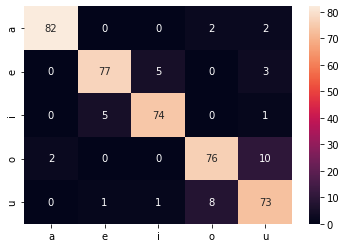

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred1));

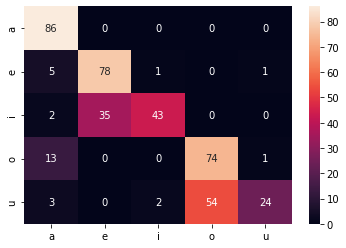

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred2));

In [21]:
accuracy_score(y_test, y_pred1)

0.9052132701421801

In [22]:
accuracy_score(y_test, y_pred2)

0.7227488151658767

In [23]:
def clasify(audio, network, n):
    rate, sig = wav.read(audio)
    mfcc_feat = psf.mfcc(sig, rate, nfft=1200)
    y, sr = lbr.load(audio)
    spec_cent = np.mean(lbr.feature.spectral_centroid(y=y, sr=sr)[0])
    spec_bw = np.mean(lbr.feature.spectral_bandwidth(y=y, sr=sr)[0])
    rolloff = np.mean(lbr.feature.spectral_rolloff(y=y, sr=sr)[0])
    zcr = np.mean(lbr.feature.zero_crossing_rate(y)[0])
    if(n == 13):
        register = list(np.mean(mfcc_feat, 0))
        coefs = [f'coef{i}' for i in range(1, 14)]
    elif(n == 17):
        aux = [spec_cent, spec_bw, rolloff, zcr]
        others = ['spec_cent', 'spec_bw', 'rolloff', 'zcr']
        register = list(np.mean(mfcc_feat, 0)) + aux
        coefs = [f'coef{i}' for i in range(1, 14)] + others
    data = pd.DataFrame(data=[register], columns=coefs)
    pred = list(network.predict(data)[0])
    classes_rev = {classes[i]:i for i in classes}
    return classes_rev[pred.index(max(pred))]

In [24]:
clasify(folder + 'e5.wav', network1, 13)

'e'

In [25]:
clasify(folder + 'e5.wav', network2, 17)

'u'

In [26]:
news = ['aR', 'eR', 'iR', 'oR', 'uR', 'aO', 'eO', 'iO', 'oO', 'uO']
print([i[0] for i in news])
print([clasify(folder + i + '.wav', network1, 13) for i in news])
print([clasify(folder + i + '.wav', network2, 17) for i in news])

['a', 'e', 'i', 'o', 'u', 'a', 'e', 'i', 'o', 'u']
['a', 'e', 'i', 'o', 'u', 'a', 'e', 'i', 'u', 'u']
['a', 'a', 'a', 'a', 'a', 'o', 'i', 'i', 'i', 'i']
